In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scanpy.api as sc
import pandas as pd
import h5py
import os
import time
import itertools
from sklearn.decomposition import PCA
import pickle
import pandas as pd
from sklearn.linear_model import LinearRegression

import scanpy.api as sc
import sceb.data_loader as dl 
import sceb.scdd as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

from matplotlib import rcParams

params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 10,
   'xtick.labelsize': 13,
   'ytick.labelsize': 13,
   'text.usetex': False,
   'text.usetex': False,
   }
rcParams.update(params)

/home/martin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
output_folder = '/home/martin/single_cell_eb/figures/figure_ercc'

# Data loading

In [3]:
# Full data
data_klein = dl.load_klein()
sc.pp.filter_genes(data_klein, min_counts=0.01*data_klein.shape[0])

/home/martin/single_cell_eb/sceb/data_loader.py:430: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  mat_klein = np.array(df_klein.iloc[:,1:].as_matrix(),dtype=int).T


In [4]:
# ercc concentration
df_ercc = dl.load_ercc_info()
data_ercc_dic = {}
ercc_lvl_dic = {}
# 10x from Zheng
data_ercc_dic['10x'] = dl.load_10x_ercc_1k()
_ = sd.get_info(data_ercc_dic['10x'])
ercc_list = list(data_ercc_dic['10x'].var_names) 
df = df_ercc.loc[ercc_list]
ercc_lvl_dic['10x'] = np.array(df.iloc[:,1], dtype=float)
# ercc_lvl_dic['10x'] = ercc_lvl_dic['10x']/10/103*2.6 *1.1/1000 *6.02*1e5
ercc_lvl_dic['10x'] = ercc_lvl_dic['10x']/10/103*3 *1.1/1000 *6.02*1e5
# Klein
data_ercc_dic['klein'] = dl.load_klein_ercc()
_ = sd.get_info(data_ercc_dic['klein'])
ercc_list = list(data_ercc_dic['klein'].var_names)
df = df_ercc.loc[ercc_list]
ercc_lvl_dic['klein'] = np.array(df.iloc[:,0], dtype=float)
ercc_lvl_dic['klein'] = ercc_lvl_dic['klein']/5000/1000 *6.02*1e5
# Svensson
data_ercc_dic['Svensson'] = dl.load_svensson_1x()
_ = sd.get_info(data_ercc_dic['Svensson'])
ercc_list = list(data_ercc_dic['Svensson'].var_names)
df = df_ercc.loc[ercc_list]
ercc_lvl_dic['Svensson'] = np.array(df.iloc[:,0], dtype=float)
ercc_lvl_dic['Svensson'] = ercc_lvl_dic['Svensson']/133*1.1/1000 *6.02*1e5
# # Svensson 2x
# data_ercc_dic['s2'] = dl.load_svensson_2x()
# _ = sd.get_info(data_ercc_dic['s2'])
# ercc_list = list(data_ercc_dic['s2'].var_names)
# df = df_ercc.loc[ercc_list]
# ercc_lvl_dic['s2'] = np.array(df.iloc[:,0], dtype=float)
# ercc_lvl_dic['s2'] = ercc_lvl_dic['s2']/8/37.4*2.6 *1.1/1000 *6.02*1e5

## Nc=1015, G=92, Nr=10534.54, Nr_bar=114.51
## Nc=953, G=92, Nr=1033.32, Nr_bar=11.23


/home/martin/single_cell_eb/sceb/data_loader.py:440: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  mat_klein_ercc = np.array(df_klein_ercc.as_matrix()).T


## Nc=2000, G=90, Nr=1360.01, Nr_bar=15.11


/home/martin/single_cell_eb/sceb/data_loader.py:451: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  mat_s1_ercc = np.array(df_s1_ercc.as_matrix()).T


# Figures

/home/martin/single_cell_eb/sceb/scdd.py:929: RuntimeWarning: divide by zero encountered in true_divide
  cv_ = np.sqrt(var_)/M[0]
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


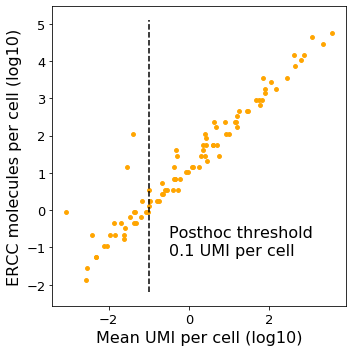

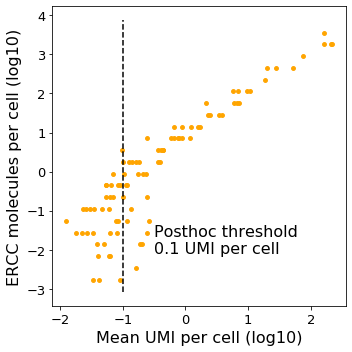

/home/martin/single_cell_eb/sceb/scdd.py:929: RuntimeWarning: divide by zero encountered in true_divide
  cv_ = np.sqrt(var_)/M[0]
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


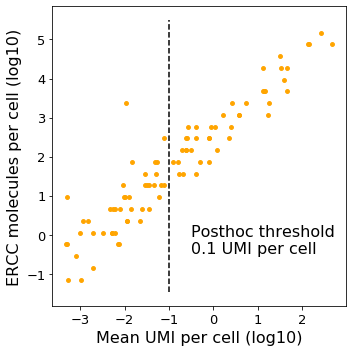

In [5]:
# Mean diagnosis
data_list = ['10x', 'klein', 'Svensson']
for dname in data_list: 
    # estimation
    size_factor = sd.dd_size_factor(data_ercc_dic[dname],verbose=False)
    M_ml,M_dd = sd.dd_1d_moment(data_ercc_dic[dname],verbose=False,size_factor=size_factor)
    var_dd = sd.M_to_var(M_dd)
    var_ml = sd.M_to_var(M_ml)
    cv_dd = sd.M_to_cv(M_dd)
    cv_ml = sd.M_to_cv(M_ml)
    y_val = np.log10(ercc_lvl_dic[dname])
    x_val = np.log10(M_dd[0])
    plt.figure(figsize=[5,5])
    plt.scatter(x_val, y_val, color='orange', marker='.', s=60)   
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    plt.annotate('Posthoc threshold\n0.1 UMI per cell', [-0.5, y_min+1], fontsize=16)
    plt.plot([-1, -1], [y_min, y_max], color='k', linestyle='--')
    plt.xlabel('Mean UMI per cell (log10)', fontsize=16)
    plt.ylabel('ERCC molecules per cell (log10)', fontsize=16)
#     plt.title(name_dic[dname])
    plt.tight_layout()
    plt.savefig(output_folder+'/mean_%s.png'%dname)
    plt.savefig(output_folder+'/mean_%s.pdf'%dname)
    plt.show()

/home/martin/single_cell_eb/sceb/scdd.py:929: RuntimeWarning: divide by zero encountered in true_divide
  cv_ = np.sqrt(var_)/M[0]
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


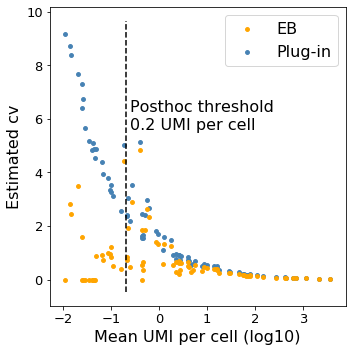

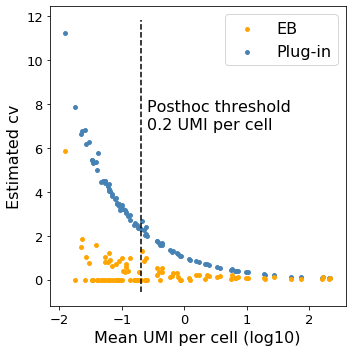

/home/martin/single_cell_eb/sceb/scdd.py:929: RuntimeWarning: divide by zero encountered in true_divide
  cv_ = np.sqrt(var_)/M[0]
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


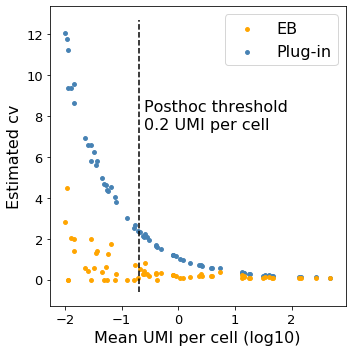

In [6]:
# cv 
data_list = ['10x', 'klein', 'Svensson']
for dname in data_list: 
    # estimation
    size_factor = sd.dd_size_factor(data_ercc_dic[dname],verbose=False)
    M_ml,M_dd = sd.dd_1d_moment(data_ercc_dic[dname],verbose=False,size_factor=size_factor)
    var_dd = sd.M_to_var(M_dd)
    var_ml = sd.M_to_var(M_ml)
    cv_dd = sd.M_to_cv(M_dd)
    cv_ml = sd.M_to_cv(M_ml)
    x_val = np.log10(M_dd[0])
    y_val = (cv_dd)
    y_val_ml = (cv_ml)
    y_val = y_val[x_val>-2]
    y_val_ml = y_val_ml[x_val>-2]
    x_val = x_val[x_val>-2]
    plt.figure(figsize=[5,5])
    plt.scatter(x_val, y_val, color='orange', marker='.', s=60, zorder=2, label='EB')
    plt.scatter(x_val, y_val_ml, color='steelblue', marker='.', s=60, label='Plug-in')
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    y_step = y_max - y_min
    plt.plot([-0.7, -0.7], [y_min, y_max], color='k', linestyle='--')
    plt.annotate('Posthoc threshold\n0.2 UMI per cell', [-0.6, y_min + 0.6*y_step], fontsize=16)
    plt.xlabel('Mean UMI per cell (log10)', fontsize=16)
    plt.ylabel('Estimated cv', fontsize=16)
#     plt.title(name_dic[dname])
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.savefig(output_folder+'/cv_%s.png'%dname)
    plt.savefig(output_folder+'/cv_%s.pdf'%dname)
    plt.show()

# time start: 0.0s
n_cell=1015, n_gene=92
# total time: 0.1s


/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


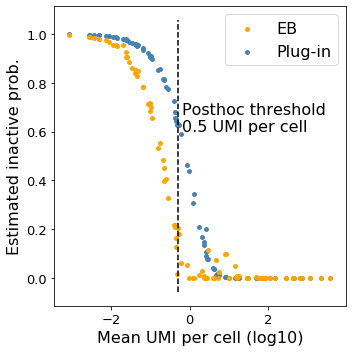

# time start: 0.0s
n_cell=953, n_gene=92
# total time: 0.1s


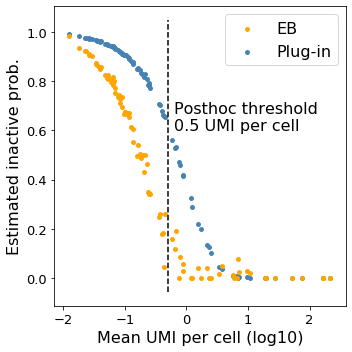

# time start: 0.0s
n_cell=2000, n_gene=90
# total time: 0.2s


/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


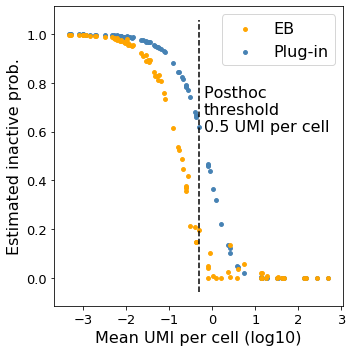

In [8]:
# inactive probability
data_list = ['10x', 'klein', 'Svensson']
for dname in data_list: 
    # estimation
    size_factor = sd.dd_size_factor(data_ercc_dic[dname],verbose=False)
    M_ml,M_dd = sd.dd_1d_moment(data_ercc_dic[dname],verbose=False,size_factor=size_factor)
    p0_ml,p0_dd = sd.dd_inactive_prob(data_ercc_dic[dname],
                                      size_factor=size_factor,relative_depth=0.2)
    x_val = np.log10(M_dd[0])
    y_val = (p0_dd)
    y_val_ml = (p0_ml)
    plt.figure(figsize=[5,5])
    plt.scatter(x_val, y_val, color='orange', marker='.', s=60, zorder=2, label='EB')
    plt.scatter(x_val, y_val_ml, color='steelblue', marker='.', s=60, label='Plug-in')
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    y_step = y_max - y_min
    plt.plot([-0.3, -0.3], [y_min, y_max], color='k', linestyle='--')
    if dname == 'Svensson':
        plt.annotate('Posthoc \nthreshold\n0.5 UMI per cell', [-0.2, 0.6], fontsize=16)
    else:
        plt.annotate('Posthoc threshold\n0.5 UMI per cell', [-0.2, 0.6], fontsize=16)
    plt.xlabel('Mean UMI per cell (log10)', fontsize=16)
    plt.ylabel('Estimated inactive prob.', fontsize=16)
#     plt.title(name_dic[dname])
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.savefig(output_folder+'/p0_%s.png'%dname)
    plt.savefig(output_folder+'/p0_%s.pdf'%dname)
    plt.show()

## Pure RNA controls in Klein data

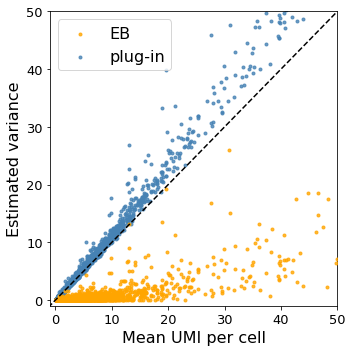

In [9]:
# var Klein
size_factor = sd.dd_size_factor(data_klein,verbose=False)
M_ml,M_dd = sd.dd_1d_moment(data_klein,verbose=False,size_factor=size_factor)
var_dd = sd.M_to_var(M_dd)
var_ml = sd.M_to_var(M_ml)
cv_dd = sd.M_to_cv(M_dd)
cv_ml = sd.M_to_cv(M_ml)
    
x_val = M_dd[0]
y_val = (var_dd)
y_val_ml = (var_ml)
plt.figure(figsize=[5,5])
plt.scatter(x_val, y_val, color='orange', alpha=0.8, marker='.', label='EB', zorder=10)
plt.scatter(x_val, y_val_ml, color='steelblue', alpha=0.8, marker='.', label='plug-in')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min, x_max], linestyle='--', color='k', zorder=11)
plt.ylim([-1,50])
plt.xlim([-1,50])
plt.xlabel('Mean UMI per cell', fontsize=16)
plt.ylabel('Estimated variance', fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(output_folder+'/var_50.png')
plt.savefig(output_folder+'/var_50.pdf')
plt.show()

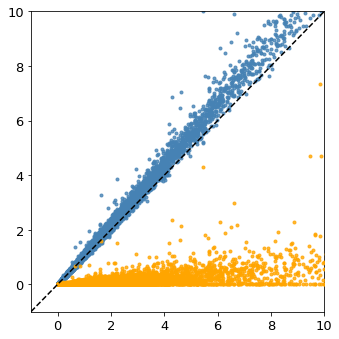

In [26]:
# var Klein
size_factor = sd.dd_size_factor(data_klein,verbose=False)
M_ml,M_dd = sd.dd_1d_moment(data_klein,verbose=False,size_factor=size_factor)
var_dd = sd.M_to_var(M_dd)
var_ml = sd.M_to_var(M_ml)
cv_dd = sd.M_to_cv(M_dd)
cv_ml = sd.M_to_cv(M_ml)
    
x_val = M_dd[0]
y_val = (var_dd)
y_val_ml = (var_ml)
plt.figure(figsize=[5,5])
plt.scatter(x_val, y_val, color='orange', alpha=0.8, marker='.', label='EB', zorder=10)
plt.scatter(x_val, y_val_ml, color='steelblue', alpha=0.8, marker='.', label='plug-in')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min, x_max], linestyle='--', color='k', zorder=11)
plt.ylim([-1,10])
plt.xlim([-1,10])
# plt.xlabel('Mean UMI counts', fontsize=16)
# plt.ylabel('Estimated variance', fontsize=16)
# plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(output_folder+'/var_10.png')
plt.savefig(output_folder+'/var_10.pdf')
plt.show()

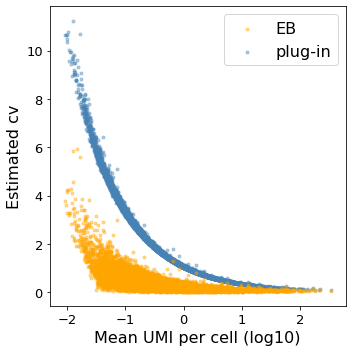

In [10]:
# cv Klein
size_factor = sd.dd_size_factor(data_klein,verbose=False)
M_ml,M_dd = sd.dd_1d_moment(data_klein,verbose=False,size_factor=size_factor)
var_dd = sd.M_to_var(M_dd)
var_ml = sd.M_to_var(M_ml)
cv_dd = sd.M_to_cv(M_dd)
cv_ml = sd.M_to_cv(M_ml)
x_val = np.log10(M_dd[0])[var_dd>1e-8]
y_val = (cv_dd[var_dd>1e-8])
y_val_ml = (cv_ml[var_dd>1e-8])
plt.figure(figsize=[5,5])
plt.scatter(x_val, y_val, color='orange', alpha=0.4, marker='.', label='EB', zorder=10)
plt.scatter(x_val, y_val_ml, color='steelblue', alpha=0.4, marker='.', label='plug-in')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.xlabel('Mean UMI per cell (log10)', fontsize=16)
plt.ylabel('Estimated cv', fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(output_folder+'/cv.png')
plt.savefig(output_folder+'/cv.pdf')
plt.show()

# Subsample experiment

In [11]:
data_full = data_ercc_dic['Svensson']
gene_list = list(data_full.var_names)
select_list = []
for gene in gene_list:
    temp = np.mean(data_full[:,gene].X)
    if temp > 10 and temp<20:
#         print(gene , temp)
        select_list.append(gene)
data_select = data_full[:, select_list]
size_factor = sd.dd_size_factor(data_select,verbose=False)
M_ml,M_dd = sd.dd_1d_moment(data_select,verbose=False,size_factor=size_factor)
p0_ml,p0_dd = sd.dd_inactive_prob(data_select, size_factor=size_factor,
                                  relative_depth=1, verbose=False)
cv_dd = sd.M_to_cv(M_dd)
cv_ml = sd.M_to_cv(M_ml)
for i in range(len(select_list)):
    print(select_list[i], cv_dd[i], cv_ml[i], p0_dd[i], p0_ml[i])

ERCC-00009 0.11212742628056103 0.31236097680044034 0.0 0.0025
ERCC-00043 0.08690177330531038 0.26441626505161636 0.0088636308652831 0.0
ERCC-00092 5.7433013093777896e-11 0.23706155777198729 0.0 0.0
ERCC-00108 0.08010697279417268 0.29482118579208566 0.00496594502005269 0.0
ERCC-00145 6.814573017845479e-11 0.2717752114229055 0.0 0.0015
ERCC-00171 0.09106935712494191 0.3056060672587938 0.010835176967664548 0.0015


In [20]:
B_list = [200, 300]
Nr_bar_list = [0.15, 0.3, 0.5, 0.75, 1, 1.5, 2]
n_rep = 100
n_rep = 10
res_dic_cv = {}
res_dic_p0 = {}
Nc,G,Nr,Nr_bar = sd.get_info(data_select)
for B in B_list:
    res_dic_cv[B] = np.zeros([n_rep, len(Nr_bar_list)], dtype=float)
    res_dic_p0[B] = np.zeros([n_rep, len(Nr_bar_list)], dtype=float)
    for i_Nr_bar_sub,Nr_bar_sub in enumerate(Nr_bar_list):
        Nc_sub = int(B / Nr_bar_sub)
        print(B, Nc_sub, Nr_bar_sub)
        for i_rep in range(n_rep):                           
            temp = sd.subsample_anndata(data_select, Nr_bar_sub*G, Nc_sub,
                                        random_state=i_rep, verbose=False)
            size_factor = sd.dd_size_factor(temp,verbose=False)
            M_ml_sub,M_dd_sub = sd.dd_1d_moment(temp,verbose=False,
                                                size_factor=size_factor)
            p0_ml_sub,p0_dd_sub = sd.dd_inactive_prob(temp,
                                                      size_factor=size_factor,
                                                      relative_depth=0.2,
                                                      verbose=False)
            cv_dd_sub = sd.M_to_cv(M_dd_sub)
            var_dd_sub = sd.M_to_var(M_dd_sub)
            res_dic_cv[B][i_rep, i_Nr_bar_sub] = np.mean(cv_dd_sub**2)
            res_dic_p0[B][i_rep, i_Nr_bar_sub] = np.mean(p0_dd_sub**2)

## Nc=2000, G=6, Nr=91.53, Nr_bar=15.25
200 1333 0.15


/home/martin/single_cell_eb/sceb/scdd.py:163: RuntimeWarning: divide by zero encountered in true_divide
  row_weight = 1/size_factor
/home/martin/single_cell_eb/sceb/scdd.py:430: RuntimeWarning: divide by zero encountered in true_divide
  tc = 1/relative_depth/size_factor


200 666 0.3
200 400 0.5
200 266 0.75
200 200 1
200 133 1.5
200 100 2
300 2000 0.15
300 1000 0.3
300 600 0.5
300 400 0.75
300 300 1
300 200 1.5
300 150 2


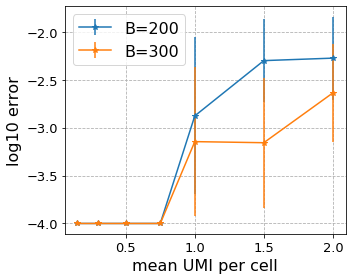

In [21]:
plt.figure(figsize=[5,4])
for B in B_list:
    error_dd = res_dic_cv[B].clip(min=1e-4)
    mean_err = np.nanmean(error_dd, axis=0)
    std_err = np.nanstd(error_dd, axis=0) / np.sqrt(np.sum(~np.isnan(error_dd), axis=0))
    y_val = np.log10(mean_err)
    y_err = np.log10(mean_err+std_err) - np.log10(mean_err)
    plt.errorbar(Nr_bar_list, y_val, y_err*3, label='B=%d'%(B), marker='*')
plt.xlabel('mean UMI per cell', fontsize=16)
plt.ylabel('log10 error', fontsize=16)
plt.legend(fontsize=16)
plt.grid(linestyle='--')
plt.tight_layout()
# plt.savefig(output_folder+'/subsample_cv.png')
# plt.savefig(output_folder+'/subsample_cv.pdf')
plt.show()

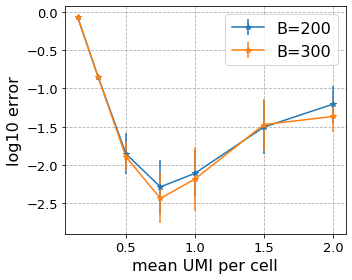

In [22]:
plt.figure(figsize=[5,4])
for B in B_list:
    error_dd = res_dic_p0[B]
    mean_err = np.nanmean(error_dd, axis=0)
    std_err = np.nanstd(error_dd, axis=0) / np.sqrt(np.sum(~np.isnan(error_dd), axis=0))
    y_val = np.log10(mean_err)
    y_err = np.log10(mean_err+std_err) - np.log10(mean_err)
    plt.errorbar(Nr_bar_list, y_val, y_err*3, label='B=%d'%(B), marker='*')
plt.xlabel('mean UMI per cell', fontsize=16)
plt.ylabel('log10 error', fontsize=16)
plt.legend(fontsize=16)
plt.grid(linestyle='--')
plt.tight_layout()
plt.savefig(output_folder+'/subsample_p0.png')
plt.savefig(output_folder+'/subsample_p0.pdf')
plt.show()